In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import datetime
from sklearn.metrics import mean_squared_error

# What did the data look like originally?

In [2]:
# Load the original data set - BEFORE transformations
original_data = pd.read_csv('original_data.csv')
original_data['Date'] = pd.to_datetime(original_data['Date'], infer_datetime_format=True)

# Display
original_data.head()

,Unnamed: 0,Date,Start_Station_Capacity,Station_Number,Status,Bike_Count,Count_Percent_Capacity
0,24,2015-07-01 08:25:00,19.0,31116,add bike,1.0,5.263158
1,26,2015-07-01 08:26:00,19.0,31116,subtract bike,0.0,0.000000
2,28,2015-07-01 09:42:00,19.0,31116,add bike,1.0,5.263158
3,30,2015-07-01 09:55:00,19.0,31116,subtract bike,0.0,0.000000
4,32,2015-07-01 10:38:00,19.0,31116,add bike,1.0,5.263158


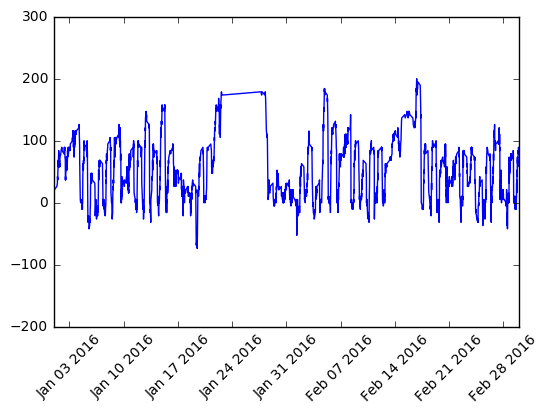

In [3]:
# For a random, specific station, 31116, what did the time series look like?
original_data_31116 = original_data[original_data['Station_Number'] == 31116]

plt.plot(original_data_31116['Date'], original_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [4]:
# Explore descriptive stats for percent capacity
original_data_31116['Count_Percent_Capacity'].describe()

count    50836.000000
mean        57.821850
std         52.297961
min        -94.736842
25%         15.789474
50%         47.368421
75%         94.736842
max        268.421053
Name: Count_Percent_Capacity, dtype: float64

# What does the data look like after transformations?

In [5]:
# Load the new, transformed data set
transformed_data = pd.read_csv('transformed_data.csv')
transformed_data['Date'] = pd.to_datetime(transformed_data['Date'], infer_datetime_format=True)

# Display
transformed_data.head()

,Unnamed: 0,Date,Station_Number,Count_Percent_Capacity
0,0,2015-07-01 08:25:00,31116,5.263158
1,1,2015-07-01 08:26:00,31116,0.000000
2,2,2015-07-01 09:42:00,31116,5.263158
3,3,2015-07-01 09:55:00,31116,0.000000
4,4,2015-07-01 10:38:00,31116,5.263158


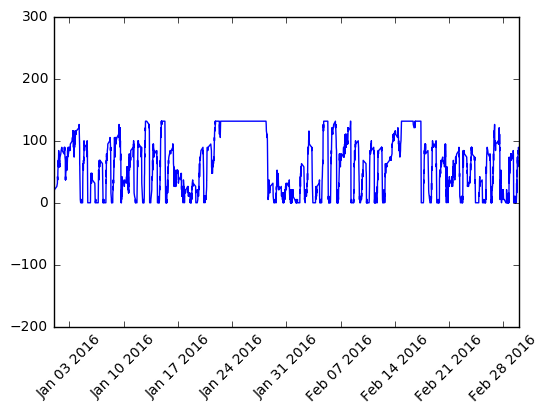

In [6]:
# For a random, specific station, 31116, what did the time series look like?
transformed_data_31116 = transformed_data[transformed_data['Station_Number'] == 31116]

plt.plot(transformed_data_31116['Date'], transformed_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [7]:
# Did tranforming change percent capacity?
transformed_data_31116['Count_Percent_Capacity'].describe()

count    50836.000000
mean        55.921208
std         44.691566
min          0.000000
25%         15.789474
50%         47.368421
75%         94.736842
max        131.578947
Name: Count_Percent_Capacity, dtype: float64

# Upsample the transformed data to every hour

In [8]:
# Use linear interpolation to find data at every hour since the start of the data for station 31116
new_series_31116 = pd.DataFrame()
add_hour = datetime.timedelta(hours=1)

temp_df = transformed_data_31116[transformed_data_31116['Station_Number'] == 31116]

start = temp_df['Date'].iloc[0] + datetime.timedelta(seconds=1)
end = temp_df['Date'].iloc[-1]
new_datetimes = []

while start <= (end + add_hour):
    new_datetimes.append(start)
    start += add_hour

new_datetimes_df = pd.DataFrame({'Date':new_datetimes, 
                                 'Station_Number':'new_datetime'})

updated_temp_df = temp_df.append(new_datetimes_df)
updated_temp_df.sort_values(by='Date', inplace=True)
#updated_temp_df.fillna(method='ffill', inplace=True)
updated_temp_df['Count_Percent_Capacity'] = updated_temp_df['Count_Percent_Capacity'].interpolate(method='linear')
updated_temp_df = updated_temp_df[updated_temp_df['Station_Number'] != 31116]
updated_temp_df['Station_Number'] = 31116

new_series_31116 = new_series_31116.append(updated_temp_df)

In [9]:
# Display
new_series_31116.head()

,Count_Percent_Capacity,Date,Station_Number,Unnamed: 0
0,2.631579,2015-07-01 08:25:01,31116,NaN
1,2.631579,2015-07-01 09:25:01,31116,NaN
2,2.631579,2015-07-01 10:25:01,31116,NaN
3,1.315789,2015-07-01 11:25:01,31116,NaN
4,2.631579,2015-07-01 12:25:01,31116,NaN


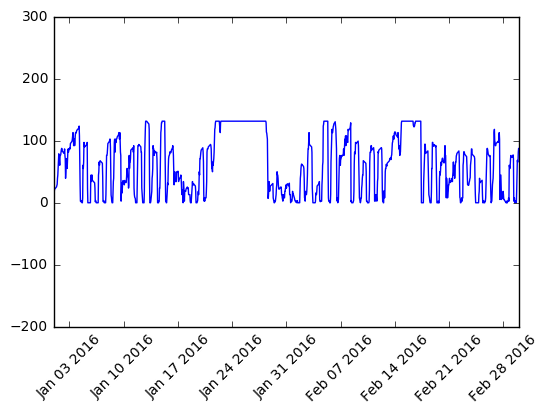

In [10]:
# Does it look like the upsampling changed the representation of the data?
plt.plot(new_series_31116['Date'], new_series_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [11]:
# Did upsampling change percent capacity?
new_series_31116['Count_Percent_Capacity'].describe()

count    10985.000000
mean        62.335961
std         48.511890
min          0.000000
25%         13.157895
50%         60.526316
75%        107.894737
max        131.578947
Name: Count_Percent_Capacity, dtype: float64

# Try an ARIMA model on the upsampled data for station 31116

In [12]:
# Take the subset of transformed data for station 31116 as a series object
series_31116 = new_series_31116.copy()
series_31116.set_index('Date', inplace=True)
series_31116 = series_31116['Count_Percent_Capacity']

# Display
series_31116 .head()

Date
2015-07-01 08:25:01    2.631579
2015-07-01 09:25:01    2.631579
2015-07-01 10:25:01    2.631579
2015-07-01 11:25:01    1.315789
2015-07-01 12:25:01    2.631579
Name: Count_Percent_Capacity, dtype: float64

In [13]:
# Create function for stationarity test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

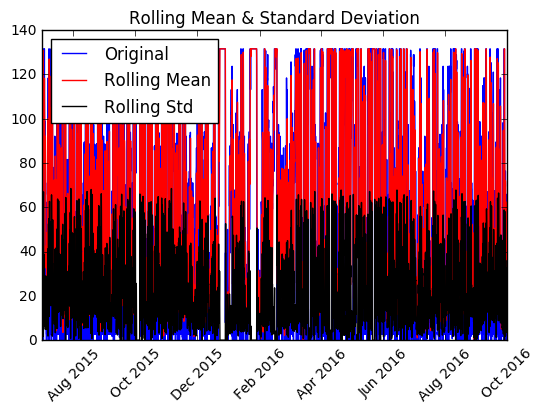

Results of Dickey-Fuller Test:
Test Statistic                -1.219115e+01
p-value                        1.284862e-22
#Lags Used                     3.800000e+01
Number of Observations Used    1.094600e+04
Critical Value (1%)           -3.430948e+00
Critical Value (5%)           -2.861804e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


In [14]:
# Run a test for stationarity on series_31116
test_stationarity(series_31116)

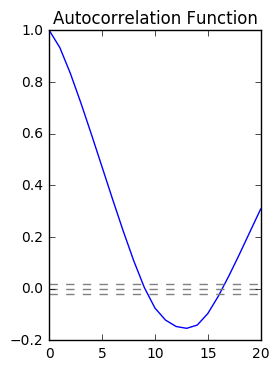

In [15]:
# Plot ACF: 
lag_acf = acf(series_31116, nlags=20)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#plt.ylim(-.05, .05)

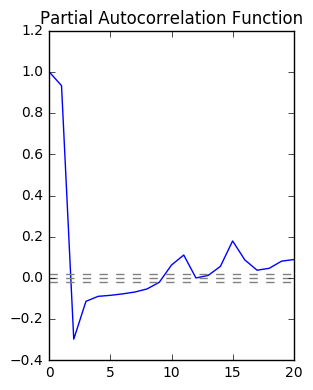

In [16]:
# Plot PACF:
lag_pacf = pacf(series_31116, nlags=20, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
#plt.ylim(-.05, .05)

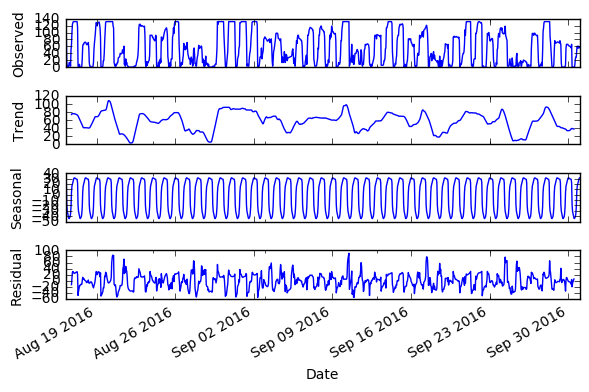

In [17]:
# Indicates a lot of seasonality
import statsmodels.tsa.api as smt
smt.seasonal_decompose(series_31116[int(len(series_31116)*.90):]).plot();

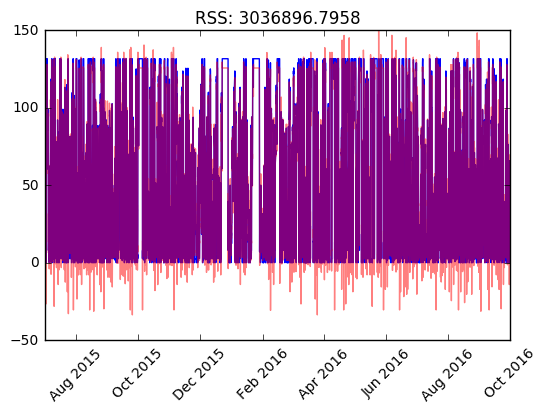

In [18]:
# AR Model
model = ARIMA(series_31116, order=(2, 0, 0))
results_AR = model.fit(disp=-1)  
plt.plot(series_31116)
plt.plot(results_AR.fittedvalues, color='red', alpha=.5)
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-series_31116)**2))
plt.xticks(rotation=45);

In [19]:
# MA Model  
model = ARIMA(series_31116, order=(0, 0, 9))
results_MA = model.fit(disp=-1)  
plt.plot(series_31116)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-series_31116)**2))
plt.xticks(rotation=45);

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

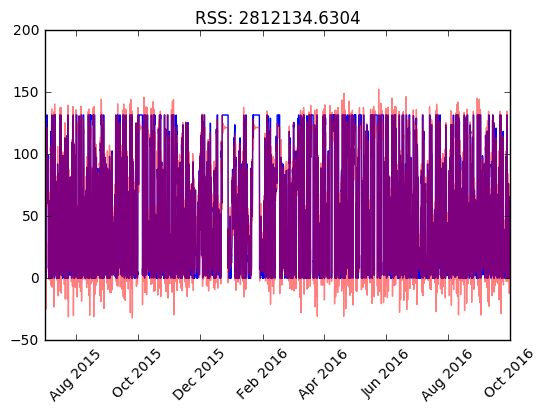

In [20]:
# Combined ARIMA Model
model = ARIMA(series_31116, order=(2, 0, 9))
results_ARIMA = model.fit(disp=-1)  
plt.plot(series_31116)
plt.plot(results_ARIMA.fittedvalues, color='red', alpha=.5)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-series_31116)**2))
plt.xticks(rotation=45);

In [21]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     Count_Percent_Capacity   No. Observations:                10985
Model:                         ARMA(2, 0)   Log Likelihood              -46461.638
Method:                           css-mle   S.D. of innovations             16.618
Date:                    Wed, 12 Apr 2017   AIC                          92931.276
Time:                            17:58:12   BIC                          92960.494
Sample:                        07-01-2015   HQIC                         92941.120
                             - 10-01-2016                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           62.2942      1.835     33.944      0.000      58.697      65.891
ar.L1.Count_Percent_Capacity     1.2105      0.009    132.870      0.000       1.193       1.228
ar.L2.Count_Percent_Capacity    -0.2968      0.009    -32.578      0.000      -0.315      -0.279
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1509           +0.0000j            1.1509            0.0000
AR.2            2.9273           +0.0000j            2.9273            0.0000
-----------------------------------------------------------------------------
"""

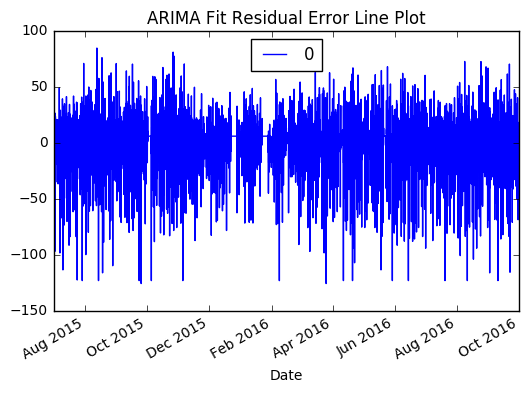

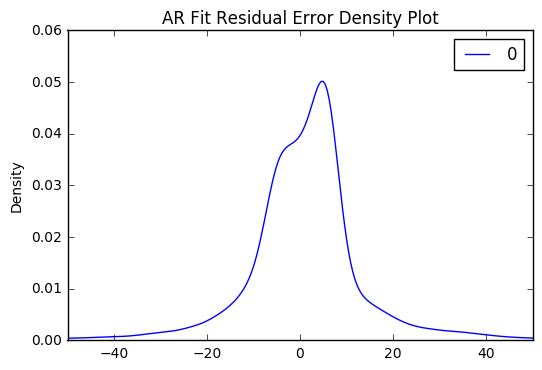

Describe residuals:
                  0
count  10985.000000
mean       0.001928
std       16.627798
min     -125.596797
25%       -5.151356
50%        1.634525
75%        5.982150
max       84.654551


In [22]:
# plot AR residual errors
residuals = pd.DataFrame(results_AR.resid)
residuals.plot()
plt.title('ARIMA Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.xlim(-50,50)
plt.title('AR Fit Residual Error Density Plot')
plt.show()

print('Describe residuals:')
print(residuals.describe())

### *Remember to add in mentions to Analytics Vidhya  and Machine Learning Mastery for using their code and articles*

# AR MODEL - ORDER (2, 0, 0)

In [23]:
# Rolling Forecast
X = series_31116
size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history_AR = [x for x in train]
predictions_AR = list()
for t in range(len(test)):
    model_AR = ARIMA(history_AR, order=(2,0,0))
    model_fit_AR = model_AR.fit(disp=0)
    output_AR = model_fit_AR.forecast()
    yhat_AR = output_AR[0]
    predictions_AR.append(yhat_AR)
    obs_AR = test[t]
    history_AR.append(obs_AR)
    print('predicted=%f, expected=%f' % (yhat_AR, obs_AR))

predicted=13.885826, expected=2.631579
predicted=6.221082, expected=2.631579
predicted=7.776207, expected=5.263158
predicted=10.958449, expected=5.263158
predicted=10.179220, expected=2.631579
predicted=6.994797, expected=2.631579
predicted=7.771666, expected=55.263158
predicted=71.435880, expected=81.578947
predicted=87.706474, expected=97.368421
predicted=99.022181, expected=97.368421
predicted=94.349919, expected=97.368421
predicted=94.350180, expected=92.105263
predicted=87.983507, expected=97.368421
predicted=95.908405, expected=98.245614
predicted=95.412560, expected=96.491228
predicted=93.031036, expected=93.684211
predicted=90.154881, expected=92.631579
predicted=89.712393, expected=91.578947
predicted=88.750870, expected=90.526316
predicted=87.789221, expected=92.105263
predicted=90.011096, expected=60.526316
predicted=51.342530, expected=18.421053
predicted=9.739780, expected=2.631579
predicted=3.104403, expected=0.000000
predicted=4.597057, expected=0.000000
predicted=5.3755

Test MSE: 217.016
Test RMSE: 14.731


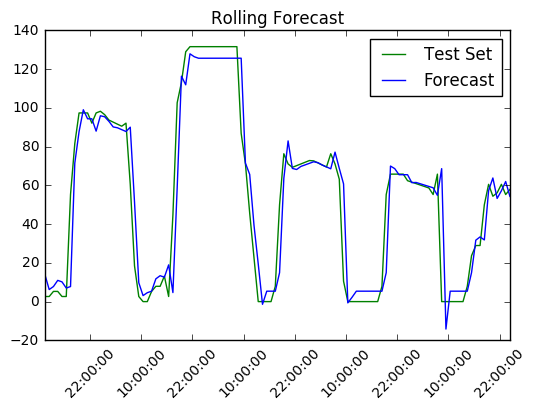

In [24]:
# Make temp df to handle dates and prediction values
pred_temp_df = pd.DataFrame(test)
pred_temp_df['predictions'] = predictions_AR
pred_temp_df['predictions'] = pred_temp_df['predictions'].astype(float)

# Display error rates
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**0.5)

# Plot forecasts
plt.plot(pred_temp_df['Count_Percent_Capacity'], color='green', label='Test Set')
plt.plot(pred_temp_df['predictions'], color='blue', label='Forecast')
plt.legend(loc='upper right')
plt.title('Rolling Forecast')
plt.xticks(rotation=45);

# Try to feed forecasts back into the model at each iteration

In [25]:
# Rolling Forecast with forecasts only
X = series_31116
size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history_AR = [x for x in train]
predictions_AR = list()
for t in range(len(test)):
    model_AR = ARIMA(history_AR, order=(2,0,0))
    model_fit_AR = model_AR.fit(disp=0)
    output_AR = model_fit_AR.forecast()
    yhat_AR = output_AR[0]
    predictions_AR.append(yhat_AR)
    obs_AR = test[t]
    history_AR.append(yhat_AR) # add in forecast instead of observed value
    print('predicted=%f, expected=%f' % (yhat_AR, obs_AR))

predicted=13.885826, expected=2.631579
predicted=19.834844, expected=2.631579
predicted=25.258653, expected=5.263158
predicted=30.059431, expected=5.263158
predicted=34.262183, expected=2.631579
predicted=37.925772, expected=2.631579
predicted=41.114018, expected=55.263158
predicted=43.886826, expected=81.578947
predicted=46.297899, expected=97.368421
predicted=48.394222, expected=97.368421
predicted=50.216710, expected=97.368421
predicted=51.801097, expected=92.105263
predicted=53.178417, expected=97.368421
predicted=54.375806, expected=98.245614
predicted=55.416705, expected=96.491228
predicted=56.321595, expected=93.684211
predicted=57.108235, expected=92.631579
predicted=57.792096, expected=91.578947
predicted=58.386889, expected=90.526316
predicted=58.903717, expected=92.105263
predicted=59.353101, expected=60.526316
predicted=59.743775, expected=18.421053
predicted=60.083435, expected=2.631579
predicted=60.378574, expected=0.000000
predicted=60.635325, expected=0.000000
predicted

Test MSE: 1901.799
Test RMSE: 43.610


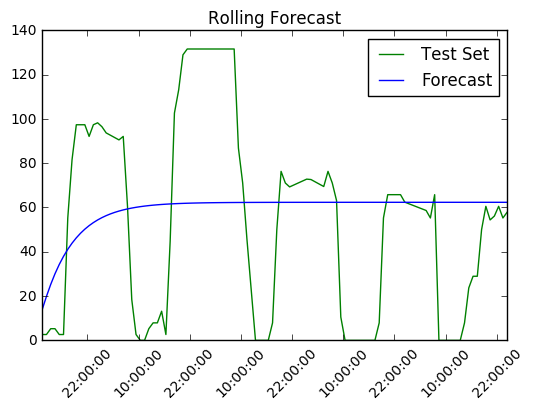

In [26]:
# Make temp df to handle dates and prediction values
pred_temp_df = pd.DataFrame(test)
pred_temp_df['predictions'] = predictions_AR
pred_temp_df['predictions'] = pred_temp_df['predictions'].astype(float)

# Display error rates
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**0.5)

# Plot forecasts
plt.plot(pred_temp_df['Count_Percent_Capacity'], color='green', label='Test Set')
plt.plot(pred_temp_df['predictions'], color='blue', label='Forecast')
plt.legend(loc='upper right')
plt.title('Rolling Forecast')
plt.xticks(rotation=45);

# Make 3 step forecasts with corrections in between

In [27]:
# Rolling Forecast with steps = 3
X = series_31116
size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history_AR = [x for x in train]
predictions_AR = list()
count = 1
for t in range(len(test)):
    model_AR = ARIMA(history_AR, order=(2,0,0))
    model_fit_AR = model_AR.fit(disp=0)
    output_AR = model_fit_AR.forecast()
    yhat_AR = output_AR[0]
    predictions_AR.append(yhat_AR)
    obs_AR = test[t]
    if count < 3:
        count += 1
        history_AR.append(yhat_AR)
    else:
        history_AR.append(obs_AR)
        count = 1
    print('predicted=%f, expected=%f' % (yhat_AR, obs_AR))

predicted=13.885826, expected=2.631579
predicted=19.834844, expected=2.631579
predicted=25.258653, expected=5.263158
predicted=5.873166, expected=5.263158
predicted=10.918272, expected=2.631579
predicted=16.839534, expected=2.631579
predicted=5.323436, expected=55.263158
predicted=11.027989, expected=81.578947
predicted=17.131481, expected=97.368421
predicted=119.887263, expected=97.368421
predicted=121.584816, expected=97.368421
predicted=116.977193, expected=92.105263
predicted=80.816296, expected=97.368421
predicted=75.883351, expected=98.245614
predicted=73.256550, expected=96.491228
predicted=99.641290, expected=93.684211
predicted=97.355790, expected=92.631579
predicted=93.659872, expected=91.578947
predicted=87.349206, expected=90.526316
predicted=83.942325, expected=92.105263
predicted=81.073114, expected=60.526316
predicted=53.759137, expected=18.421053
predicted=52.501145, expected=2.631579
predicted=52.981278, expected=0.000000
predicted=-10.148362, expected=0.000000
predict

Test MSE: 816.817
Test RMSE: 28.580


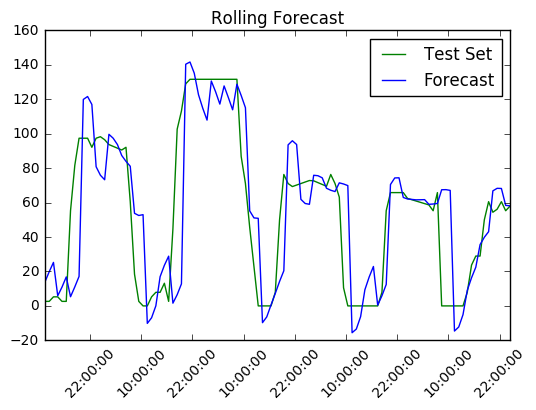

In [28]:
# Make temp df to handle dates and prediction values
pred_temp_df = pd.DataFrame(test)
pred_temp_df['predictions'] = predictions_AR
pred_temp_df['predictions'] = pred_temp_df['predictions'].astype(float)

# Display error rates
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**0.5)

# Plot forecasts
plt.plot(pred_temp_df['Count_Percent_Capacity'], color='green', label='Test Set')
plt.plot(pred_temp_df['predictions'], color='blue', label='Forecast')
plt.legend(loc='upper right')
plt.title('Rolling Forecast')
plt.xticks(rotation=45);

# Is the AR model really learning? Try training on only 1% of the data

In [29]:
# Rolling Forecast 
# train on only the 98th-99th percent of data
X = series_31116
size = int(len(X) * 0.99)
train, test = X[(int(len(X) * 0.98)):size], X[size:len(X)]
history_AR = [x for x in train]
predictions_AR = list()
for t in range(len(test)):
    model_AR = ARIMA(history_AR, order=(2,0,0))
    model_fit_AR = model_AR.fit(disp=0)
    output_AR = model_fit_AR.forecast()
    yhat_AR = output_AR[0]
    predictions_AR.append(yhat_AR)
    obs_AR = test[t]
    history_AR.append(obs_AR)
    print('predicted=%f, expected=%f' % (yhat_AR, obs_AR))

predicted=12.164840, expected=2.631579
predicted=5.583622, expected=2.631579
predicted=6.419343, expected=5.263158
predicted=9.251845, expected=5.263158
predicted=8.751902, expected=2.631579
predicted=5.811780, expected=2.631579
predicted=6.202742, expected=55.263158
predicted=63.818207, expected=81.578947
predicted=83.985103, expected=97.368421
predicted=96.557207, expected=97.368421
predicted=93.365179, expected=97.368421
predicted=93.437087, expected=92.105263
predicted=87.554524, expected=97.368421
predicted=94.634858, expected=98.245614
predicted=94.615324, expected=96.491228
predicted=92.517742, expected=93.684211
predicted=89.762387, expected=92.631579
predicted=89.195637, expected=91.578947
predicted=88.267959, expected=90.526316
predicted=87.336741, expected=92.105263
predicted=89.369032, expected=60.526316
predicted=53.563273, expected=18.421053
predicted=11.696933, expected=2.631579
predicted=3.188262, expected=0.000000
predicted=3.889270, expected=0.000000
predicted=4.46069

Test MSE: 226.138
Test RMSE: 15.038


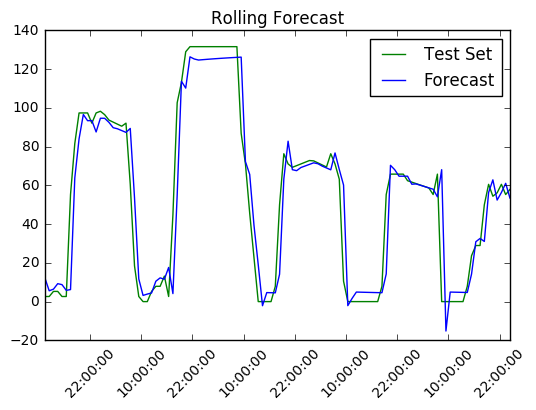

In [30]:
# Make temp df to handle dates and prediction values
pred_temp_df = pd.DataFrame(test)
pred_temp_df['predictions'] = predictions_AR
pred_temp_df['predictions'] = pred_temp_df['predictions'].astype(float)

# Display error rates
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**0.5)

# Plot forecasts
plt.plot(pred_temp_df['Count_Percent_Capacity'], color='green', label='Test Set')
plt.plot(pred_temp_df['predictions'], color='blue', label='Forecast')
plt.legend(loc='upper right')
plt.title('Rolling Forecast')
plt.xticks(rotation=45);

# Try the predictions method instead

In [31]:
# Try predictions instead
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat

X = series_31116
size = int(len(X) * 0.99)
train, test = X[(int(len(X) * 0.98)):size], X[size:len(X)]
history_AR = [x for x in train]
predictions_AR = list()
for t in range(len(test)):
    model_AR = ARIMA(history_AR, order=(2,0,0))
    model_fit_AR = model_AR.fit(trend='nc', disp=False)
    ar_coef = model_fit_AR.arparams
    yhat = predict(ar_coef, history_AR)
    predictions_AR.append(yhat)
    obs = test[t]
    #history_AR.append(obs)
    history_AR.append(yhat)
    print('predicted=%.3f, expected=%.3f' % (yhat, obs))
rmse = (mean_squared_error(test, predictions_AR))**0.5
print('Test RMSE: %.3f' % rmse)

predicted=8.217, expected=2.632
predicted=7.933, expected=2.632
predicted=7.572, expected=5.263
predicted=7.215, expected=5.263
predicted=6.873, expected=2.632
predicted=6.548, expected=2.632
predicted=6.238, expected=55.263
predicted=5.943, expected=81.579
predicted=5.663, expected=97.368
predicted=5.396, expected=97.368
predicted=5.142, expected=97.368
predicted=4.901, expected=92.105
predicted=4.671, expected=97.368
predicted=4.452, expected=98.246
predicted=4.244, expected=96.491
predicted=4.045, expected=93.684
predicted=3.856, expected=92.632
predicted=3.676, expected=91.579
predicted=3.505, expected=90.526
predicted=3.342, expected=92.105
predicted=3.187, expected=60.526
predicted=3.039, expected=18.421
predicted=2.898, expected=2.632
predicted=2.764, expected=0.000
predicted=2.636, expected=0.000
predicted=2.514, expected=5.263
predicted=2.398, expected=7.895
predicted=2.288, expected=7.895
predicted=2.182, expected=13.158
predicted=2.082, expected=2.632
predicted=1.986, expect

Test MSE: 4690.859
Test RMSE: 68.490


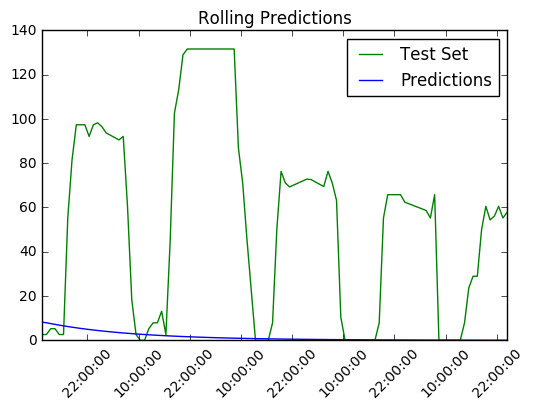

In [32]:
# Make temp df to handle dates and prediction values
pred_temp_df = pd.DataFrame(test)
pred_temp_df['predictions'] = predictions_AR
pred_temp_df['predictions'] = pred_temp_df['predictions'].astype(float)

# Display error rates
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**0.5)

# Plot forecasts
plt.plot(pred_temp_df['Count_Percent_Capacity'], color='green', label='Test Set')
plt.plot(pred_temp_df['predictions'], color='blue', label='Predictions')
plt.legend(loc='upper right')
plt.title('Rolling Predictions')
plt.xticks(rotation=45);

# Will SARIMA be any better?

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


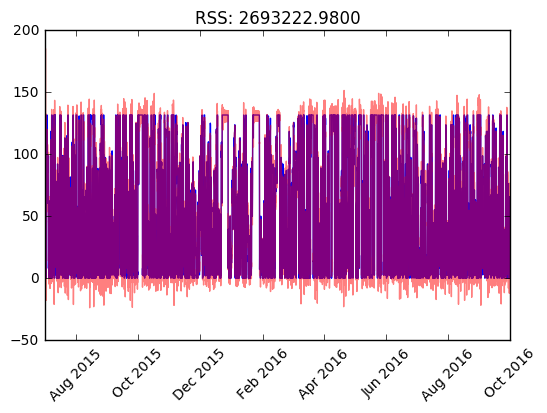

In [33]:
# SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(X, 
                enforce_stationarity=False,
                enforce_invertibility=False,
                order=(2, 0, 9), 
                seasonal_order=(0, 1, 2, 4))
results_SARIMAX = model.fit()
plt.plot(X)
plt.plot(results_SARIMAX.fittedvalues, color='red', alpha=.5)
plt.title('RSS: %.4f'% sum((results_SARIMAX.fittedvalues-X)**2))
plt.xticks(rotation=45);

In [34]:
results_SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:            Count_Percent_Capacity   No. Observations:                10985
Model:             SARIMAX(2, 0, 9)x(0, 1, 2, 4)   Log Likelihood              -45729.854
Date:                           Wed, 12 Apr 2017   AIC                          91487.709
Time:                                   18:04:12   BIC                          91589.969
Sample:                               07-01-2015   HQIC                         91522.162
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9158      0.003    614.715      0.000       1.910       1.922
ar.L2         -0.9821      0.003   -333.302      0.000      -0.988      -0.976
ma.L1         -0.8329      0.011    -75.506      0.000      -0.855      -0.811
ma.L2         -0.0360      0.018     -1.982      0.047      -0.072      -0.000
ma.L3          0.0166      0.021      0.795      0.427      -0.024       0.058
ma.L4         -0.8227      0.095     -8.622      0.000      -1.010      -0.636
ma.L5          0.8690      0.081     10.692      0.000       0.710       1.028
ma.L6          0.0812      0.015      5.321      0.000       0.051       0.111
ma.L7          0.0267      0.019      1.437      0.151      -0.010       0.063
ma.L8         -0.1358      0.090     -1.508      0.132      -0.312       0.041
ma.L9          0.0073      0.084      0.088      0.930      -0.157       0.171
ma.S.L4       -0.1603      0.094     -1.701      0.089      -0.345       0.024
ma.S.L8       -0.0117      0.023     -0.500      0.617      -0.058       0.034
sigma2       271.6062      2.921     92.978      0.000     265.881     277.332
===================================================================================
Ljung-Box (Q):                     1126.91   Jarque-Bera (JB):             56857.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -1.72
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

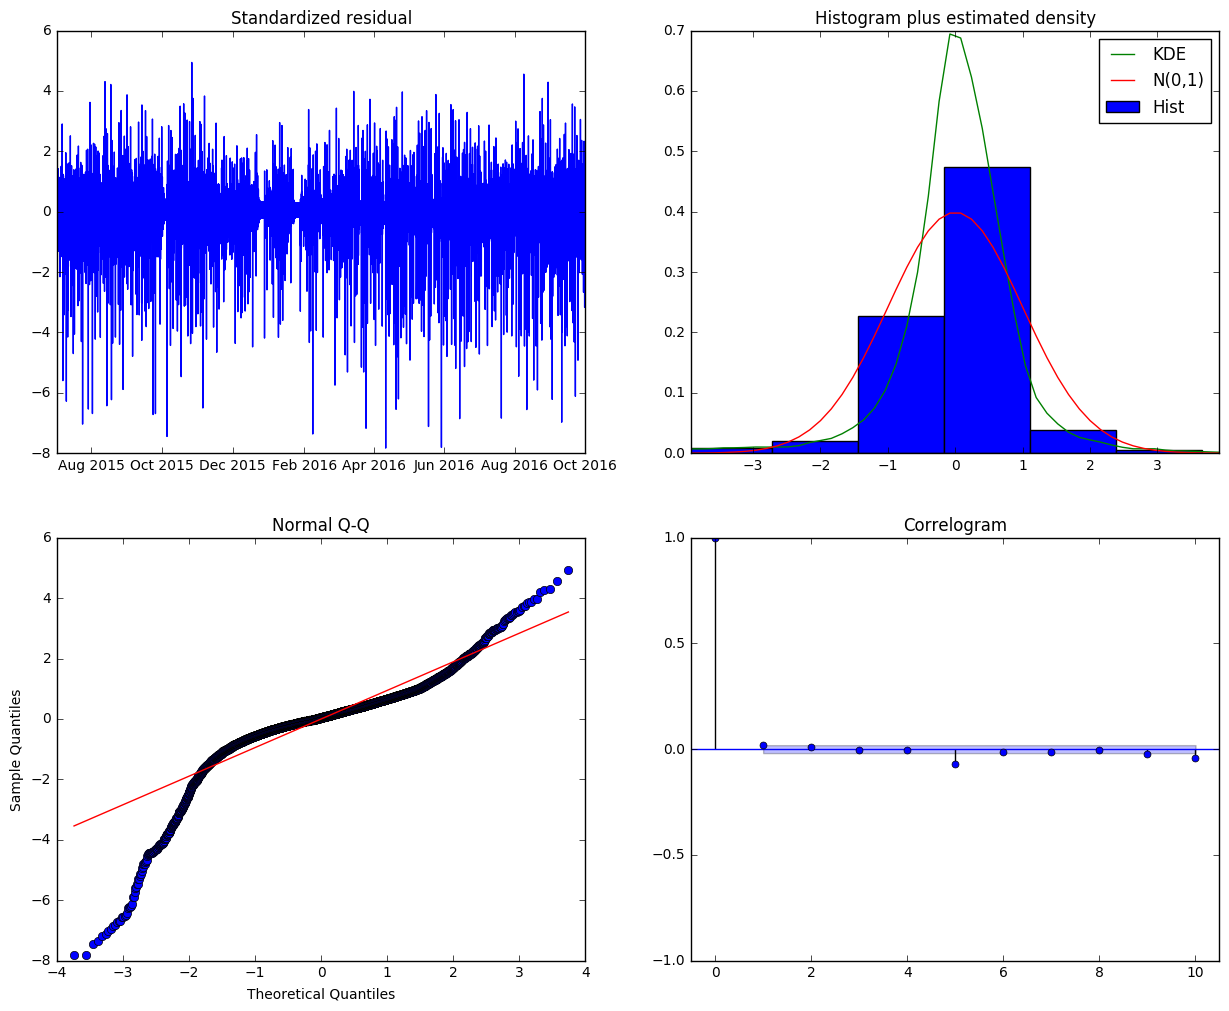

In [35]:
results_SARIMAX.plot_diagnostics(figsize=(15, 12))
plt.show()

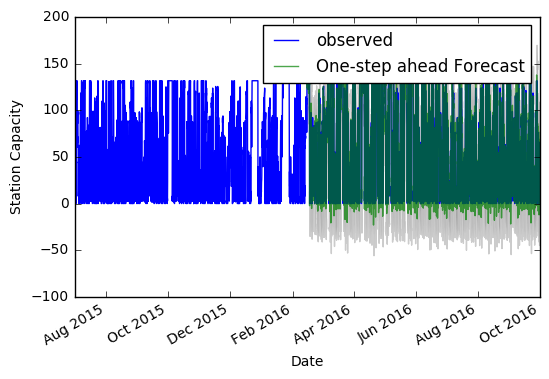

In [36]:
pred = results_SARIMAX.get_prediction(start=X.index[(int(len(X) * 0.50))], dynamic=False)
pred_ci = pred.conf_int()

ax = X.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Station Capacity')
plt.legend()

plt.show()

In [37]:
y_forecasted = pred.predicted_mean
y_truth = X[(int(len(X) * 0.50)):]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('RMSE: {:.2f}'.format(mse**0.5))

The Mean Squared Error of our forecasts is 270.99
RMSE: 16.46


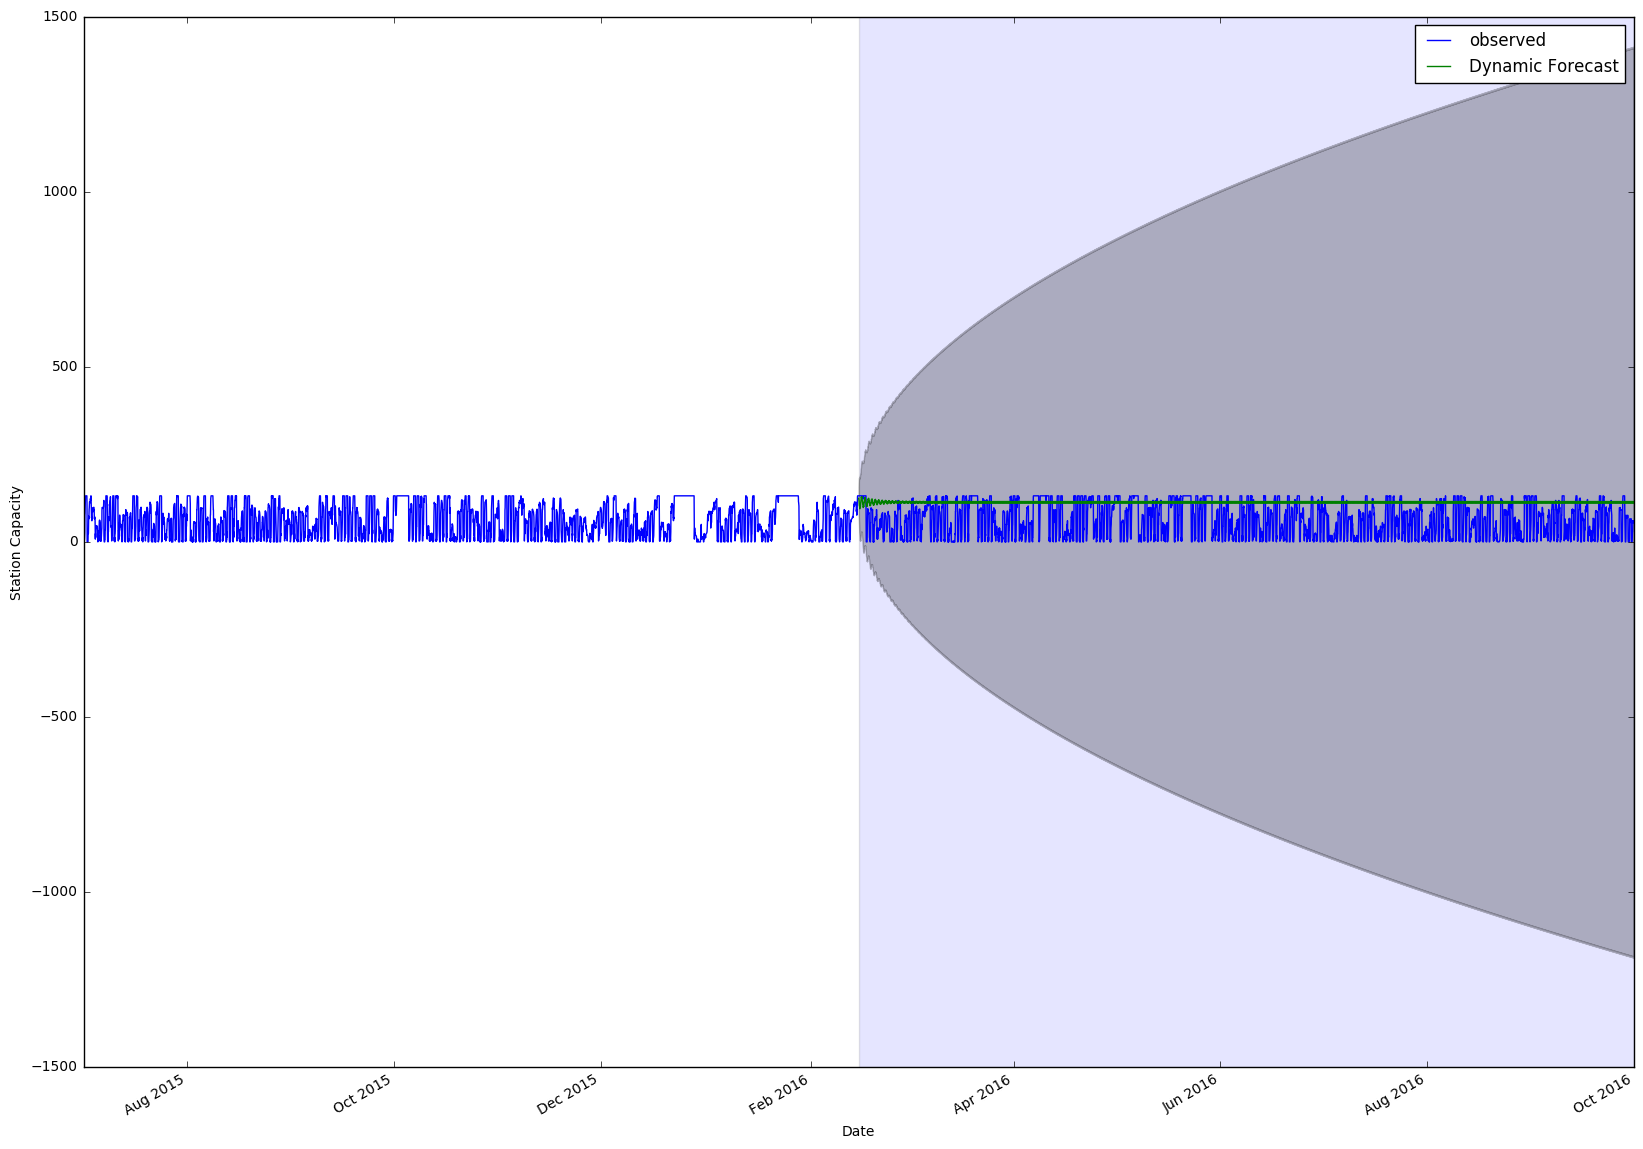

In [38]:
pred_dynamic = results_SARIMAX.get_prediction(start=X.index[(int(len(X) * 0.50))], 
                                              dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = X.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), X.index[(int(len(X) * 0.50))], X.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Station Capacity')

plt.legend()
plt.show()

In [39]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = train[(int(len(train) * 0.50)):]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('RMSE: {:.2f}'.format(mse**0.5))

The Mean Squared Error of our forecasts is 8819.39
RMSE: 93.91


# Why isn't it detecting any seasonality? Need to find better order and seasonal parameters from ACF and PACF plots. Is it an issue that the data started out stationary in the first place? No seasonality

# # USE R TO FIND THE SARIMA PARAMETERS

# Add exogenous variables to SARIMA to make a SARIMAX

In [40]:
data = pd.DataFrame(X)
data.reset_index(drop=False, inplace=True)
data['Date'] = data['Date'].astype(str)
data['day_of_week'] = data['Date'].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).weekday())
data['month'] = data['Date'].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)
data['week_number'] = data['Date'].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).strftime('%V'))
data['week_number'] = data['week_number'].astype(int)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Count_Percent_Capacity,day_of_week,month,week_number
Date,,,,
2015-07-01 08:25:01,2.631579,2,7,27
2015-07-01 09:25:01,2.631579,2,7,27
2015-07-01 10:25:01,2.631579,2,7,27
2015-07-01 11:25:01,1.315789,2,7,27
2015-07-01 12:25:01,2.631579,2,7,27


In [42]:
# SARIMAX Model with exogs
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = data['Count_Percent_Capacity'].astype(float)
size = int(len(X) * 0.99)
X_train, X_test = X[(int(len(X) * 0.0)):size], X[size:len(X)]

exogs = data[['day_of_week','month','week_number']]
exogs_train, exogs_test = exogs[(int(len(exogs) * 0.0)):size], exogs[size:len(exogs)]

model2 = SARIMAX(X_train,
                exog=exogs_train,
                enforce_stationarity=False,
                enforce_invertibility=False,
                order=(2, 0, 9), 
                seasonal_order=(0, 1, 2, 12))
results_SARIMAX2 = model2.fit()
plt.plot(X_train)
plt.plot(results_SARIMAX2.fittedvalues, color='red', alpha=.5)
plt.title('RSS: %.4f'% sum((results_SARIMAX2.fittedvalues-X_train)**2))
plt.xticks(rotation=45);

KeyboardInterrupt: 

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


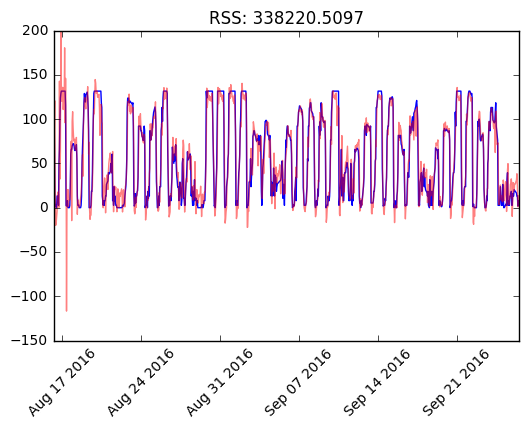

In [43]:
# SARIMAX Model without exogs
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = data['Count_Percent_Capacity'].astype(float)
size = int(len(X) * 0.99)
X_train, X_test = X[(int(len(X) * 0.90)):size], X[size:len(X)]
# Using all the training data (99%) leads to a lot more training time and increases RMSE by about 4%

exogs = data[['day_of_week','month','week_number']]
exogs_train, exogs_test = exogs[(int(len(exogs) * 0.90)):size], exogs[size:len(exogs)]

model = SARIMAX(X_train,
                #exog=exogs_train,
                enforce_stationarity=False,
                enforce_invertibility=False,
                order=(2, 0, 9), 
                seasonal_order=(0, 1, 2, 12))
results_SARIMAX = model.fit()
plt.plot(X_train)
plt.plot(results_SARIMAX.fittedvalues, color='red', alpha=.5)
plt.title('RSS: %.4f'% sum((results_SARIMAX.fittedvalues-X_train)**2))
plt.xticks(rotation=45);

In [44]:
results_SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:             Count_Percent_Capacity   No. Observations:                  989
Model:             SARIMAX(2, 0, 9)x(0, 1, 2, 12)   Log Likelihood               -3983.522
Date:                            Wed, 12 Apr 2017   AIC                           7995.043
Time:                                    18:14:07   BIC                           8063.597
Sample:                                08-16-2016   HQIC                          8021.113
                                     - 09-26-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9038      0.012    154.967      0.000       1.880       1.928
ar.L2         -0.9713      0.011    -87.064      0.000      -0.993      -0.949
ma.L1         -0.9686      0.035    -27.454      0.000      -1.038      -0.899
ma.L2          0.1673      0.050      3.379      0.001       0.070       0.264
ma.L3         -0.0975      0.056     -1.747      0.081      -0.207       0.012
ma.L4          0.1103      0.066      1.668      0.095      -0.019       0.240
ma.L5         -0.0403      0.062     -0.649      0.516      -0.162       0.081
ma.L6          0.1307      0.054      2.426      0.015       0.025       0.236
ma.L7          0.0366      0.056      0.654      0.513      -0.073       0.146
ma.L8          0.0425      0.064      0.668      0.504      -0.082       0.167
ma.L9         -0.0003      0.041     -0.006      0.995      -0.081       0.081
ma.S.L12      -0.9939      0.427     -2.330      0.020      -1.830      -0.158
ma.S.L24      -0.0053      0.042     -0.127      0.899      -0.087       0.076
sigma2       272.7329    117.363      2.324      0.020      42.705     502.760
===================================================================================
Ljung-Box (Q):                       64.82   Jarque-Bera (JB):              1461.61
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -1.16
Prob(H) (two-sided):                  0.68   Kurtosis:                         8.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

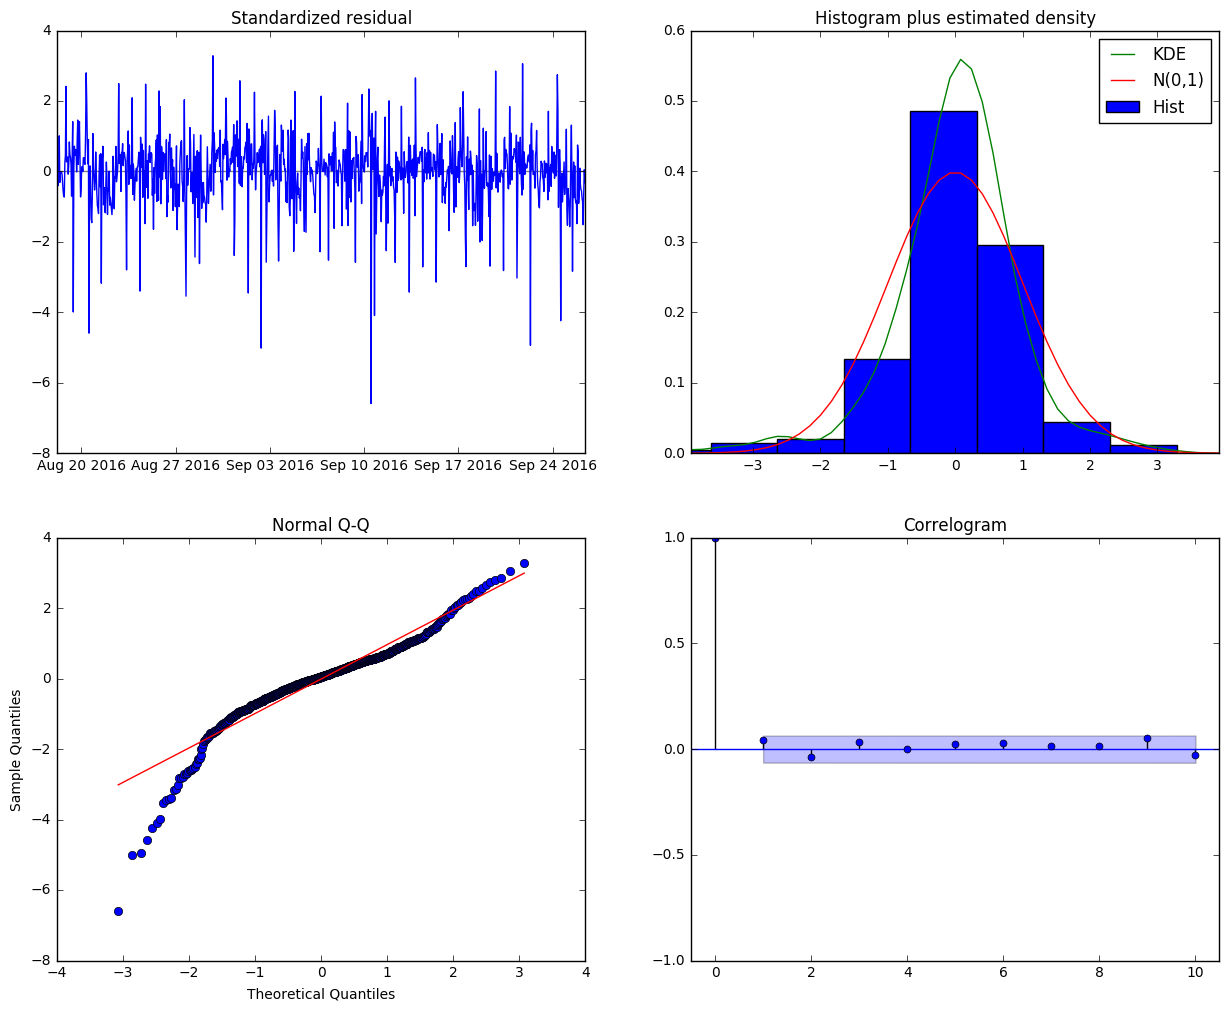

In [45]:
results_SARIMAX.plot_diagnostics(figsize=(15, 12))
plt.show()

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:1924: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


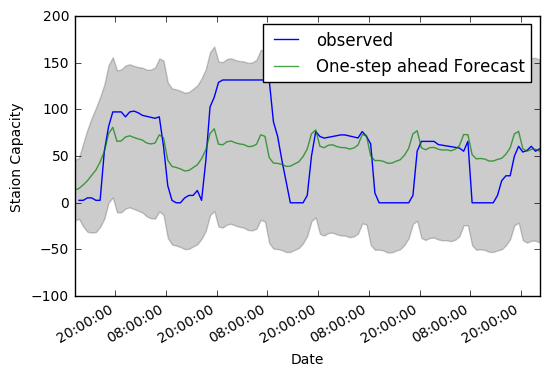

In [46]:
pred = results_SARIMAX.get_prediction(start=X_train.index[-1], 
                                      end=X_test.index[-1],
                                      exog=exogs_test,
                                      dynamic=False)
pred_ci = pred.conf_int()

ax = X_test.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Staion Capacity')
plt.legend()

plt.show()

In [47]:
y_forecasted = pred.predicted_mean
y_truth = X_test

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('RMSE: {:.2f}'.format(mse**0.5))

The Mean Squared Error of our forecasts is 1298.66
RMSE: 36.04


/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/statespace/sarimax.py:1924: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


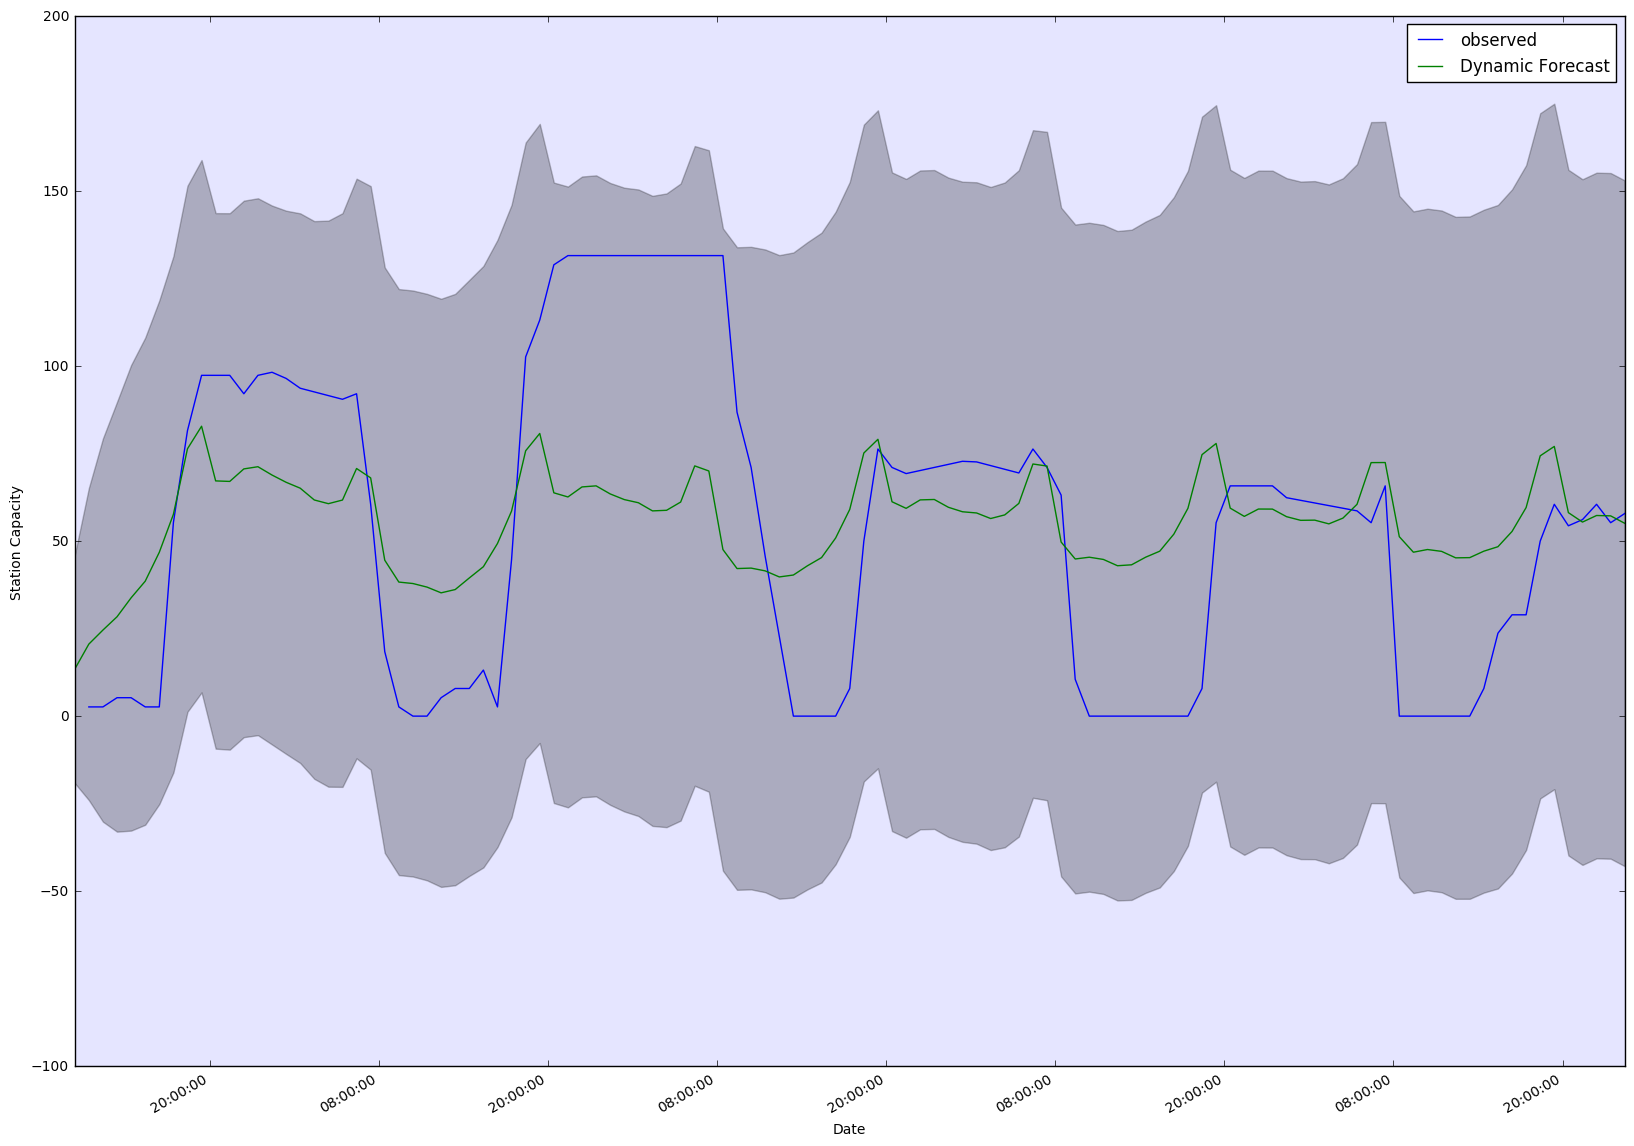

In [48]:
pred_dynamic = results_SARIMAX.get_prediction(start=X_train.index[-1], 
                                      end=X_test.index[-1],
                                      exog=exogs_test,
                                      dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = X_test.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), X.index[(int(len(X) * 0.50))], X.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Station Capacity')

plt.legend()
plt.show()

In [49]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = X_test

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('RMSE: {:.2f}'.format(mse**0.5))

The Mean Squared Error of our forecasts is 1347.76
RMSE: 36.71


# Generalize the above with the first 5 stations

In [ ]:
for station in sorted(list(transformed_data['Station_Number'].unique()))[0:5]:
    
    #Load in transformed data, mask for station, upsample per hour
    series = pd.DataFrame()
    add_hour = datetime.timedelta(hours=1)

    df = transformed_data[transformed_data['Station_Number'] == station]

    start = df['Date'].iloc[0] + datetime.timedelta(seconds=1)
    end = df['Date'].iloc[-1]
    new_datetimes = []

    while start <= (end + add_hour):
        new_datetimes.append(start)
        start += add_hour

    new_datetimes_df = pd.DataFrame({'Date':new_datetimes, 
                                     'Station_Number':'new_datetime'})

    updated_df = df.append(new_datetimes_df)
    updated_df.sort_values(by='Date', inplace=True)
    updated_df['Count_Percent_Capacity'] = updated_df['Count_Percent_Capacity'].interpolate(method='linear')
    updated_df = updated_df[updated_df['Station_Number'] != station]
    updated_df['Station_Number'] = station

    series = series.append(updated_df)
    
    
    # Create the series for ARIMA use
    series_station = series.copy()
    series_station.set_index('Date', inplace=True)
    series_station = series_station['Count_Percent_Capacity']
    
    # Test stationarity
    print('Station {}'.format(station))
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series_station, autolag='AIC')
    if dftest[0] < dftest[4]['1%']:
        print('We are 99% confident that the series is stationary\n')
    elif dftest[0] < dftest[4]['5%']:
        print('We are 95% confident that the series is stationary\n')
    elif dftest[0] < dftest[4]['10%']:
        print('We are 90% confident that the series is stationary\n')
    else:
        print('We are not confident that the series is stationary\n')
        
    # Create ACF and PACF plots as inputs to the ARIMA model
    
    # Plot ACF: 
    lag_acf = acf(series_station, nlags=20)
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(series_station)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series_station)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    plt.show()
    
    # Plot PACF:
    lag_pacf = pacf(series_31116, nlags=20, method='ols')
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()